In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

from scipy.stats import multivariate_normal
from IPython.display import clear_output

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.dpi'] = 300
import sklearn
import sklearn.cluster
from flow_ssl import FlowLoss

from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture

from itertools import chain

%load_ext autoreload
%autoreload 2

In [2]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [3]:
from scipy.spatial.distance import cdist

def get_decision_boundary(f_xx, f_yy, prior):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    classes = prior.classify(torch.from_numpy(f_points).float()).detach().numpy()
    return classes

In [25]:
def plot_fig(data, flow, loss_fn):
    plt.figure(figsize=(11, 5))
    inv = flow(torch.from_numpy(data)).detach().numpy()

    plt.subplot(121)
    plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")

    delta = 0.1
    obsmax = [20, 20]
    obsmin = [-20, -20]
    X, Y = np.mgrid[obsmin[0]:obsmax[0]:delta, obsmin[1]:obsmax[1]:delta] 
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    pos = pos.reshape((-1, 2))
    for i in range(len(loss_fn.prior.means)):
        pdfs = np.exp(loss_fn.prior.log_prob(torch.FloatTensor(pos)).detach().numpy()).reshape(X.shape)
        plt.contour(X, Y, pdfs, zorder=2)
        plt.scatter(loss_fn.prior.means[i][0].detach().numpy(), loss_fn.prior.means[i][1].detach().numpy(),
                    color='r', s=20, zorder=2)

    plt.subplot(122)
    grid_points = 100
    grid_freq = 10
    z_lims = [-7.5, 7.5]
    x_lims = [-4, 4]
    line_z = np.linspace(*z_lims, grid_points)
    line_x = np.linspace(*x_lims, grid_points)
    xx_z, yy_z = np.meshgrid(line_z, line_z)
    xx_x, yy_x = np.meshgrid(line_x, line_x)

    f_xx, f_yy = grid_image(flow, xx_x, yy_x)
    classes = get_decision_boundary(f_xx, f_yy, loss_fn.prior)
    class_values = np.unique(classes)
    colors = np.zeros_like(classes)
    for i, value in enumerate(class_values):
        colors[classes == value] = i
    colors[colors > 5] = 0
    plt.contourf(xx_x, yy_x, colors.reshape(xx_x.shape), cmap="Pastel1", alpha=0.5)
    plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    plt.title(r'Classifier')
    plt.xlim(x_lims)
    plt.ylim(x_lims)
    
    plt.show()

In [68]:
def plot_full_fig(data, flow, loss_fn):
    plt.figure(figsize=(12, 15))

    grid_points = 50
    grid_freq = 5
    z_lims = np.array([-7.5, 7.5])
    x_lims = np.array([-1.5, 2.5])
    line_z = np.linspace(*z_lims, grid_points)
    line_x = np.linspace(*x_lims, grid_points)
    xx_z, yy_z = np.meshgrid(line_z, line_z)
    xx_x, yy_x = np.meshgrid(line_x, line_x)


    inv = flow(torch.from_numpy(data)).detach().numpy()

    plt.subplot(321)
    plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    f_xx, f_yy = grid_image(flow, xx_x, yy_x)
    plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
    f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
    plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
    plt.title(r'$z = f(X)$')
#     plt.xlim(z_lims)
#     plt.ylim(z_lims)

    plt.subplot(322)
    zs = []
    for i in range(len(loss_fn.prior.means)):
        z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
        zs.append(z)
        plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
    plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
    plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    plt.title(r'$z \sim p(z)$')
#     plt.xlim(z_lims)
#     plt.ylim(z_lims)

    plt.subplot(323)
    plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
    plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
    plt.title(r'$X \sim p(X)$')
#     plt.xlim(x_lims)
#     plt.ylim(x_lims)


    plt.subplot(324)
    g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
    plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
    g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
    plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
    xs = []

    for z in zs:
        x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
        plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
        xs.append(x)

    for i in range(int(np.max(labels) + 1)):
        plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")

    plt.title(r'$X = g(z)$')
#     plt.xlim(x_lims)
#     plt.ylim(x_lims)

    plt.subplot(325)
    classes = get_decision_boundary(f_xx, f_yy, loss_fn.prior)
    plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
    plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
    for i in range(int(np.max(labels) + 1)):
        plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    plt.title(r'Classifier')
#     plt.xlim(x_lims)
#     plt.ylim(x_lims)

In [70]:
# TODO: add em trainng of gmm?

def train_flow(loss_fn, opt_flow, z, sldj, batch_y):
    loss = loss_fn(z, sldj, batch_y)
    opt_flow.zero_grad()
    loss.backward()
    opt_flow.step()
    return loss.item()

def train_gmm(loss_fn, opt_gmm, z, sldj, batch_y, reg=True):
    loss = -(loss_fn.prior.log_prob(z, batch_y)).mean()
    loss_value = loss_fn(z, sldj, batch_y).item()

    if reg:
        means = loss_fn.prior.means
        means_norms = torch.norm(means, dim=1)**2
        dists = means_norms[:, None] + means_norms[None, :] - 2*means@means.t()
        loss += -(dists * (dists < 36.).float()).sum()

    opt_gmm.zero_grad()
    loss.backward()
    opt_gmm.step()
    return loss_value

def train_jointly(loss_fn, opt1, opt2, z, sldj, batch_y, reg=True):
    loss = loss_fn(z, sldj, batch_y)
    loss_val = loss.item()
    if reg:
        means = loss_fn.prior.means
        means_norms = torch.norm(means, dim=1)**2
        dists = means_norms[:, None] + means_norms[None, :] - 2*means@means.t()
        loss += -(dists * (dists < 36.).float()).sum()
    opt1.zero_grad()
    opt2.zero_grad()
    loss.backward()
    opt1.step()
    opt2.step()
    return loss_val
    

def ssl_train(data, labels, n_classes, lr_init=1e-3, lr_gmm_init=1e-1, gmm_trainable=True,
              joint=False, flow_iters=200, gmm_iters=200,
              plotting=True, r=5, epochs=2000, print_freq=100, wd=1e-2):
    
    phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1] + 0.5
    mean_x = np.cos(phis) * r
    mean_y = np.sin(phis) * r
    means_init = np.hstack([mean_x[:, None], mean_y[:, None]])
    means_init = torch.from_numpy(means_init).float()

    means = torch.tensor(means_init, dtype=torch.float, requires_grad=gmm_trainable)
    prior = SSLGaussMixture(means=means)
    prior.weights.requires_grad = gmm_trainable
    prior.inv_cov_stds.requires_grad = False  # TODO: change later

    flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)
    loss_fn = FlowLoss(prior, k=1)

    n_ul = np.sum(labels == -1)
    n_l = np.shape(labels)[0] - n_ul
    batch_size = n_l

    labeled_data = data[labels != -1]
    labeled_labels = labels[labels != -1]
    unlabeled_data = data[labels == -1]
    unlabeled_labels = labels[labels == -1]

    opt_flow = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True],
                                 lr=lr_init, weight_decay=wd)
    opt_gmm = torch.optim.Adam([prior.means, prior.weights, prior.inv_cov_stds],
                               lr=lr_gmm_init, weight_decay=0)

    # Training loop
    loss_vals = []
    count = 0
    flow_training_stage = True

    for t in range(epochs):
        batch_idx = np.random.choice(n_ul, size=batch_size)
        batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
        batch_x = np.vstack([batch_x, labeled_data])
        batch_y = np.hstack([batch_y, labeled_labels])
        batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)

        z = flow(batch_x)
        sldj = flow.logdet()

        if joint:
            loss_val = train_jointly(loss_fn, opt_flow, opt_gmm, z, sldj, batch_y)
        else:
            if flow_training_stage:
                loss_val = train_flow(loss_fn, opt_flow, z, sldj, batch_y)
            else:
                loss_val = train_gmm(loss_fn, opt_gmm, z, sldj, batch_y)
        
        loss_vals.append(loss_val)
        
        if t % print_freq == 0:
            print('iter %s:' % t, 'loss = %.3f \t' % loss_val,
                  'log det J = %.3f' % sldj.sum())

        count += 1
        if (flow_training_stage and count == flow_iters) or\
            (not flow_training_stage and count == gmm_iters):
            count = 0
            flow_training_stage = not flow_training_stage
            if plotting:
                plot_fig(data, flow, loss_fn)
            print('training {}'.format('flow' if flow_training_stage else 'gmm'))


        if t == int(epochs * 0.5) or t == int(epochs * 0.8):
            for p in opt_flow.param_groups:
                p["lr"] /= 10
            for p in opt_gmm.param_groups:
                p["lr"] /= 10
                
    if plotting:
        plot_fig(data, flow, loss_fn)
        
    return flow, loss_fn

## Pinwheel

In [96]:
data, labels = make_dataset_from_npz("../../data/toy_datasets/pinwheel.npz")
labels[labels==2] = -1

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/polina/flow_ssl/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 22.709 	 log det J = 5.443
iter 100: loss = -1.443 	 log det J = 136.573
iter 200: loss = -2.537 	 log det J = 141.026


/Users/polina/flow_ssl/flow_ssl/distributions.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


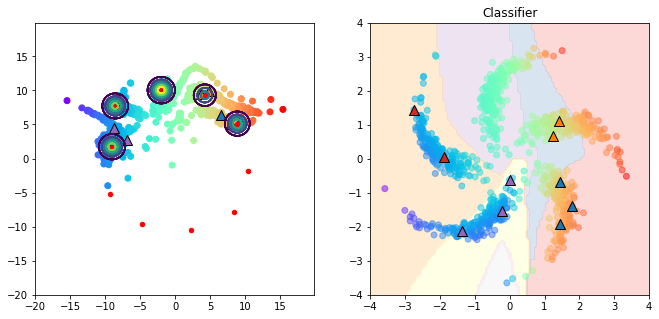

training gmm
iter 300: loss = -2.969 	 log det J = 136.831


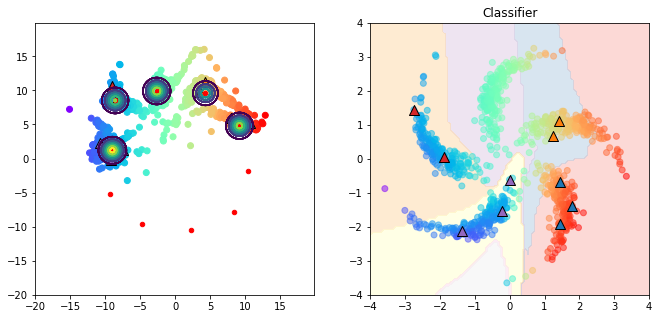

training flow
iter 400: loss = -2.580 	 log det J = 149.060
iter 500: loss = -3.367 	 log det J = 144.188
iter 600: loss = -3.126 	 log det J = 148.234


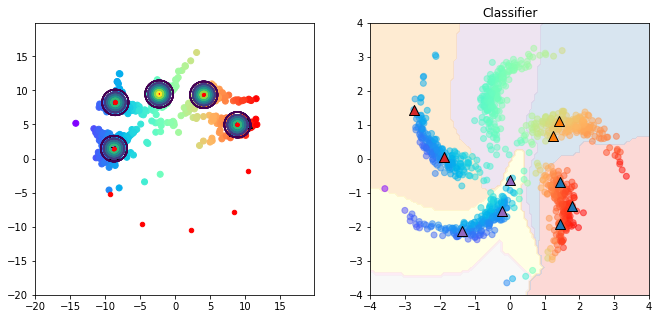

training gmm
iter 700: loss = -3.313 	 log det J = 147.333


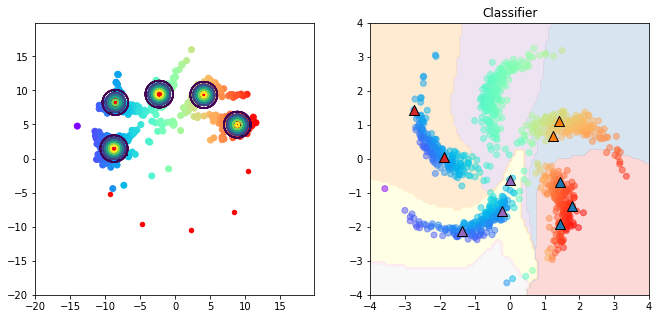

training flow
iter 800: loss = -3.005 	 log det J = 146.394
iter 900: loss = -2.917 	 log det J = 148.777
iter 1000: loss = -3.928 	 log det J = 146.946


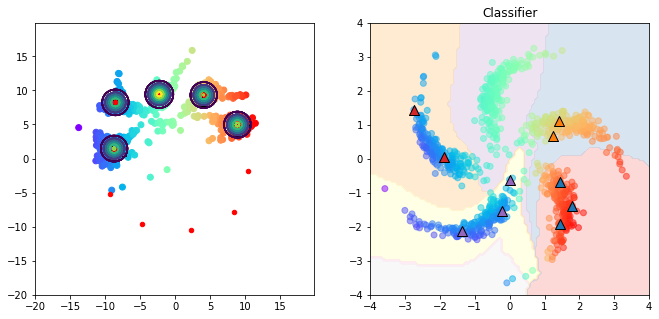

training gmm
iter 1100: loss = -3.590 	 log det J = 148.442


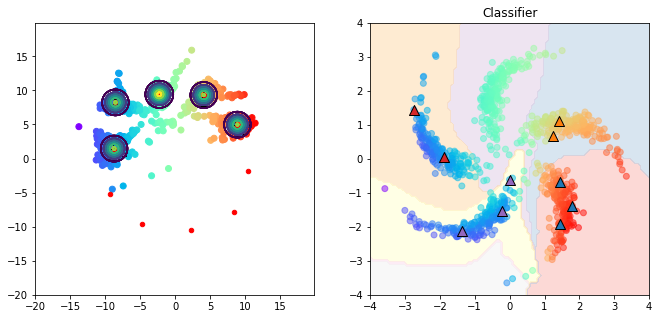

training flow


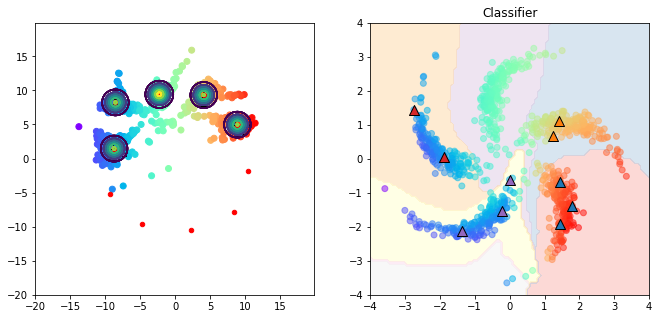

In [100]:
flow, loss_fn = ssl_train(data, labels, 10, r=8., lr_init=1e-4, lr_gmm_init=1e-1,
                          joint=True, flow_iters=300, gmm_iters=100, epochs=1200)

## Moons

In [ ]:
data, labels = make_moons_ssl()

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/polina/flow_ssl/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 13.608 	 log det J = 2.517
iter 100: loss = -4.534 	 log det J = 150.871


/Users/polina/flow_ssl/flow_ssl/distributions.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


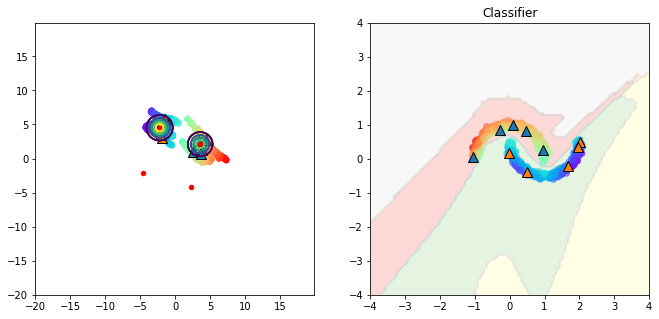

training gmm
iter 200: loss = -5.569 	 log det J = 172.027


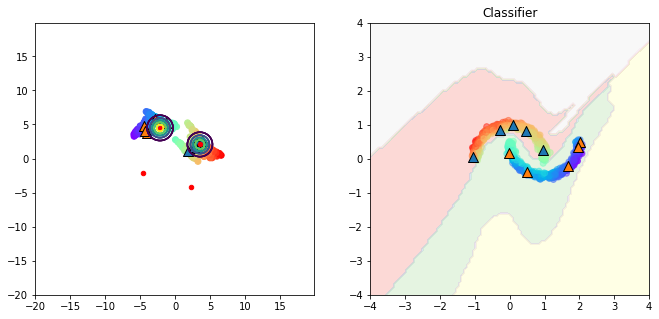

training flow
iter 300: loss = -5.595 	 log det J = 180.515
iter 400: loss = -6.493 	 log det J = 193.030


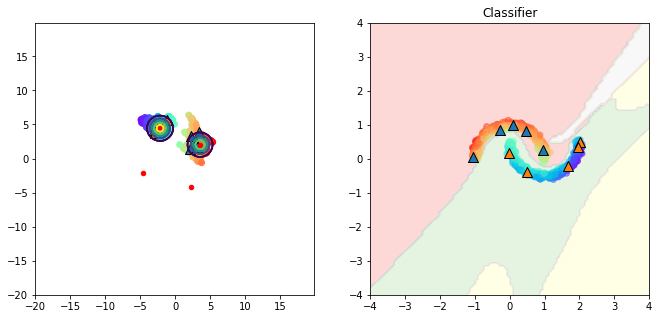

training gmm
iter 500: loss = -7.253 	 log det J = 204.464


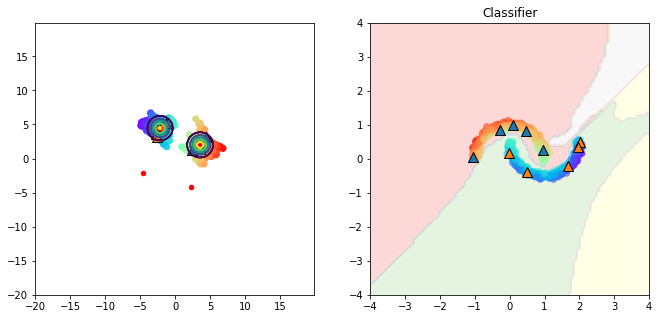

training flow
iter 600: loss = -7.697 	 log det J = 210.268
iter 700: loss = -7.527 	 log det J = 212.381


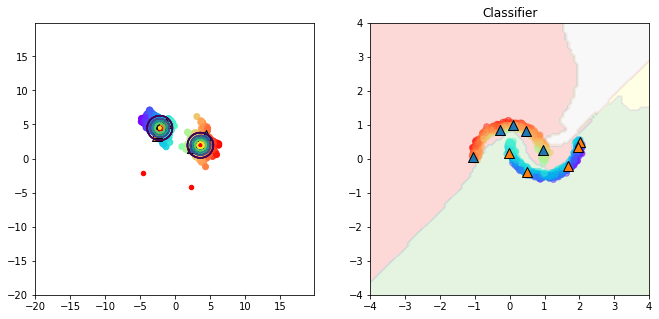

training gmm
iter 800: loss = -7.413 	 log det J = 212.724


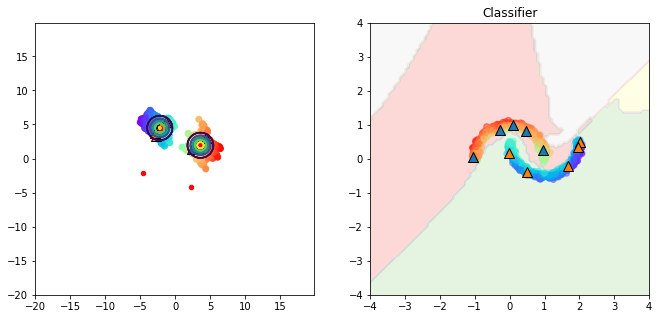

training flow
iter 900: loss = -7.712 	 log det J = 212.771


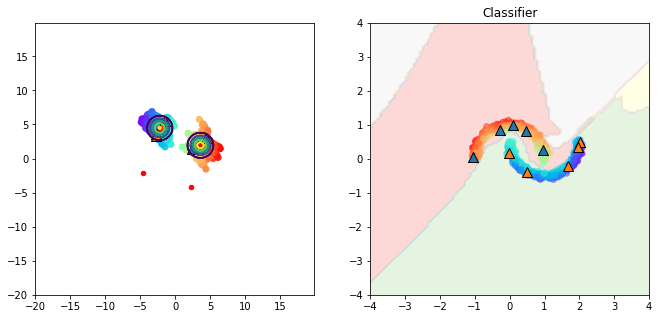

In [44]:
flow, loss_fn = ssl_train(data, labels, 4,
                      joint=True, flow_iters=200, gmm_iters=100, epochs=1000)

In [45]:
F.softmax(loss_fn.prior.weights)

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([5.2078e-01, 4.7828e-01, 5.1058e-04, 4.3110e-04],
       grad_fn=<SoftmaxBackward>)

## Circles

In [52]:
data, labels = make_circles_ssl()

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/polina/flow_ssl/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 12.866 	 log det J = 0.505
iter 100: loss = -4.300 	 log det J = 160.691


/Users/polina/flow_ssl/flow_ssl/distributions.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


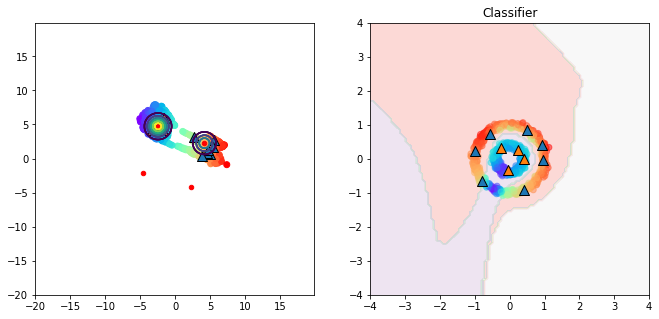

training gmm
iter 200: loss = -4.751 	 log det J = 184.636


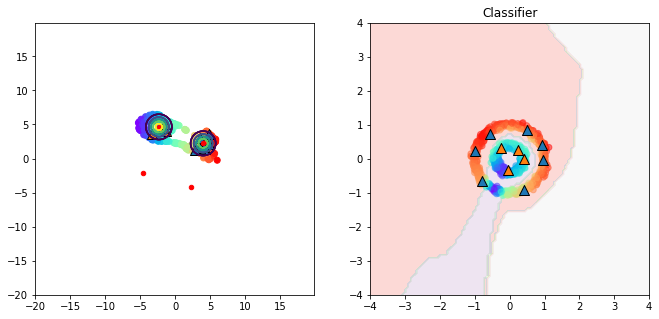

training flow
iter 300: loss = -5.696 	 log det J = 190.934
iter 400: loss = -6.199 	 log det J = 203.534


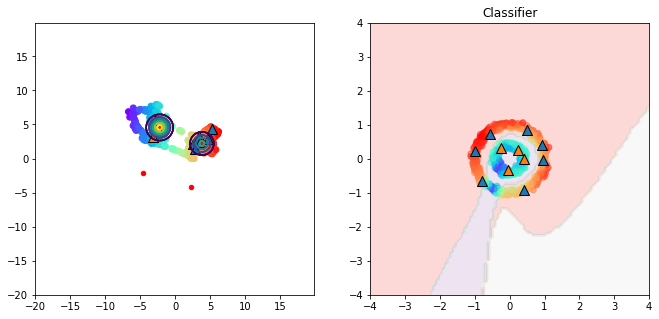

training gmm
iter 500: loss = -6.842 	 log det J = 218.737


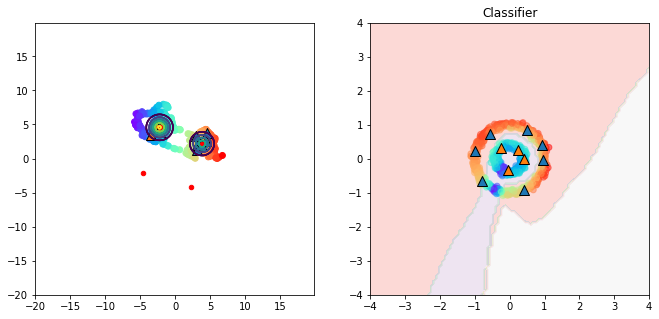

training flow
iter 600: loss = -6.698 	 log det J = 219.937
iter 700: loss = -6.601 	 log det J = 220.564


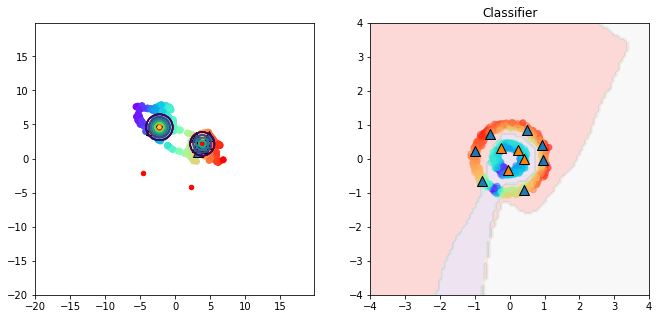

training gmm
iter 800: loss = -7.382 	 log det J = 222.036


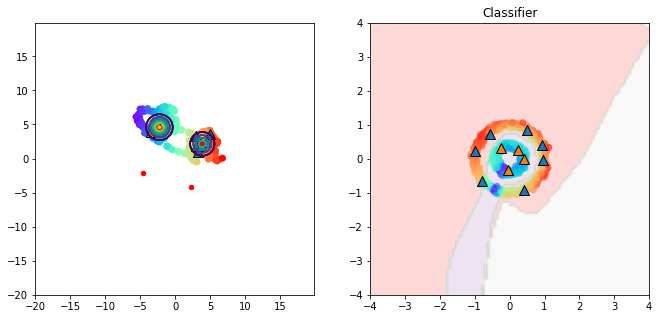

training flow
iter 900: loss = -7.052 	 log det J = 222.626


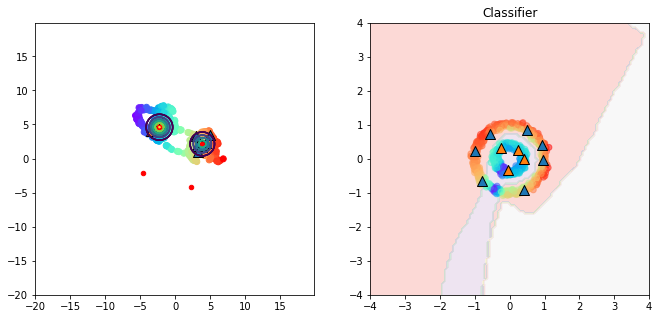

In [53]:
flow, loss_fn = ssl_train(data, labels, 4,
                          joint=True, flow_iters=200, gmm_iters=100, epochs=1000)

In [54]:
F.softmax(loss_fn.prior.weights)

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([4.3168e-01, 5.6728e-01, 5.1602e-04, 5.1714e-04],
       grad_fn=<SoftmaxBackward>)

## 8 Gaussians

In [58]:
data, labels = make_dataset_from_npz("../../data/toy_datasets/8gauss.npz")

/Users/polina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/polina/flow_ssl/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 17.210 	 log det J = -0.405
iter 100: loss = -2.250 	 log det J = 222.007


/Users/polina/flow_ssl/flow_ssl/distributions.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


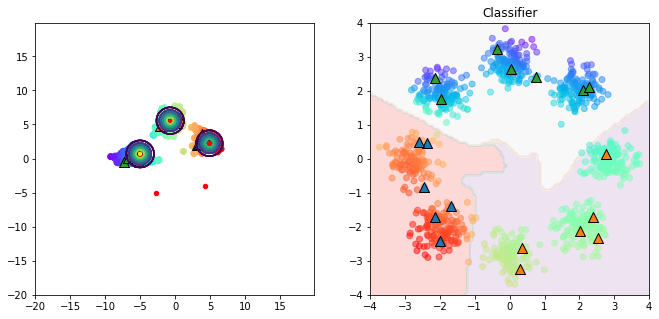

training gmm
iter 200: loss = -3.002 	 log det J = 243.885


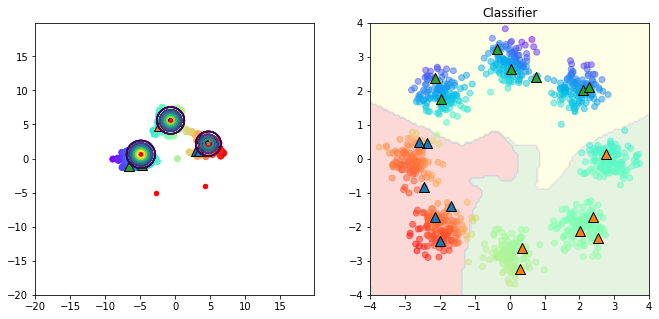

training flow
iter 300: loss = -3.678 	 log det J = 264.638
iter 400: loss = -4.147 	 log det J = 286.929


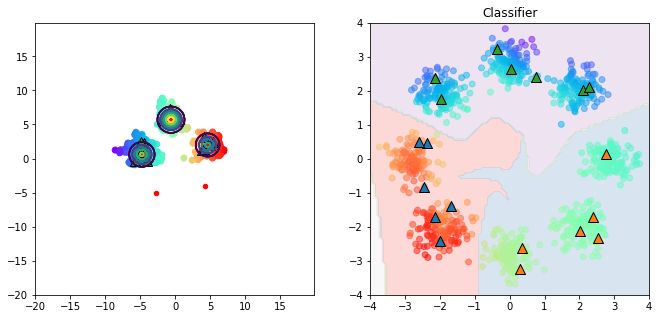

training gmm
iter 500: loss = -4.902 	 log det J = 308.416


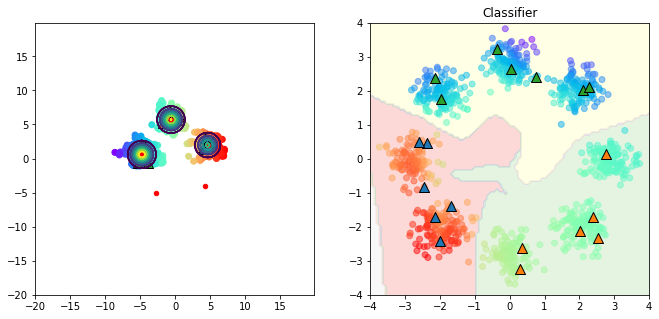

training flow
iter 600: loss = -5.075 	 log det J = 313.314
iter 700: loss = -5.267 	 log det J = 314.928


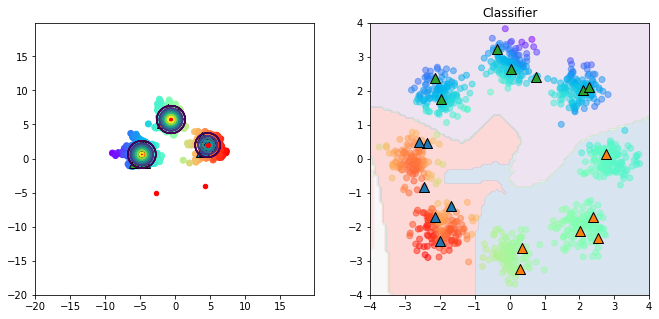

training gmm
iter 800: loss = -5.326 	 log det J = 323.200


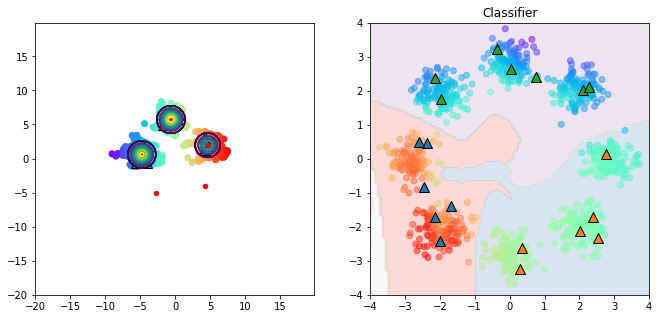

training flow
iter 900: loss = -5.244 	 log det J = 317.788


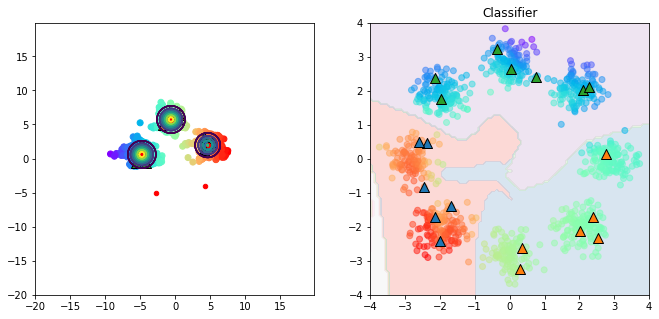

In [59]:
flow, loss_fn = ssl_train(data, labels, 5,
                          joint=True, flow_iters=200, gmm_iters=100, epochs=1000)

/Users/polina/flow_ssl/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)
/Users/polina/flow_ssl/flow_ssl/distributions.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


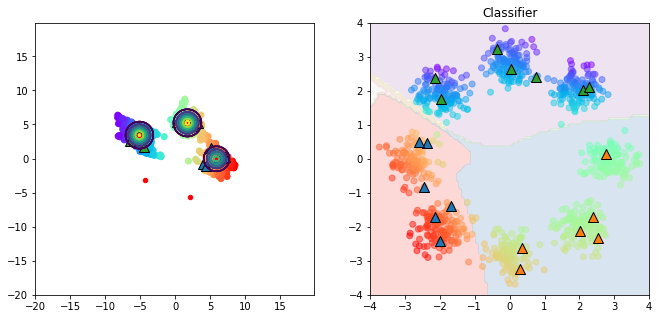

In [423]:
plot_fig(data, flow, loss_fn)